# Computer Vision Project: Face Covering Detection

- **Name:** Sajeel Nadeem Alam
- **ID:** 240045404



# Google Colab Setup

Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Code', 'Personal_Video', 'CW_Dataset', 'Models', 'test_function.ipynb']


Getting data from Google Drive. This code is adapted from Lab 6 [1]

In [ ]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2024_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CV2024_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2024_CW_Dataset.zip

# Importing Essential Libraries

In [ ]:
import os
from skimage import io
import matplotlib.pyplot as plt
import pandas as pd

import cv2
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn import svm, metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from skimage.feature import hog
from skimage.transform import resize
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_auc_score, accuracy_score
from collections import Counter

import torchvision
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image

import time
import copy
from joblib import dump, load
import csv

In [ ]:
randomState = 42

# Reading Data

Some parts of this code are adapted from Lab 6 [1]

In [ ]:
dataset_path = "./CV2024_CW_Dataset"

for root, dirs, files in os.walk(dataset_path):
    print(root, "contains", len(files), "files")

./CV2024_CW_Dataset contains 0 files
./CV2024_CW_Dataset/train contains 0 files
./CV2024_CW_Dataset/train/labels contains 2394 files
./CV2024_CW_Dataset/train/images contains 2394 files
./CV2024_CW_Dataset/test contains 0 files
./CV2024_CW_Dataset/test/labels contains 458 files
./CV2024_CW_Dataset/test/images contains 458 files


In [ ]:
def import_selected_data(images_path, labels_path):      # this functions goes over the given directories and
    images = []                                          # extracts the images and corresponding labels
    labels = []

    filenames = [file for file in sorted(os.listdir(images_path)) if file.endswith('.jpeg')]

    for file in filenames:
        img_path = os.path.join(images_path, file)
        img = io.imread(img_path)
        images.append(img)

        label_filename = os.path.splitext(file)[0] + ".txt"
        label_path = os.path.join(labels_path, label_filename)

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                label = f.read().strip()
        else:
            label = None

        labels.append(label)

    return images, labels

In [ ]:
trainImagesPath = "CV2024_CW_Dataset/train/images"
trainLabelsPath = "CV2024_CW_Dataset/train/labels"
testImagesPath = "CV2024_CW_Dataset/test/images"
testLabelsPath = "CV2024_CW_Dataset/test/labels"

xTrain, yTrain = import_selected_data(trainImagesPath, trainLabelsPath)   # calling the data extraction function for
xTest, yTest = import_selected_data(testImagesPath, testLabelsPath)       # both train and test images

print(f"Loaded {len(xTrain)} training images and {len(yTrain)} labels")
print(f"Loaded {len(xTest)} testing images and {len(yTest)} labels")

print("Training Images classes", Counter(yTrain))
print("Testing Images classes", Counter(yTest))

Loaded 2394 training images and 2394 labels
Loaded 458 testing images and 458 labels
Training Images classes Counter({'1': 1940, '0': 376, '2': 78})
Testing Images classes Counter({'1': 388, '0': 51, '2': 19})


Displaying Sample Image

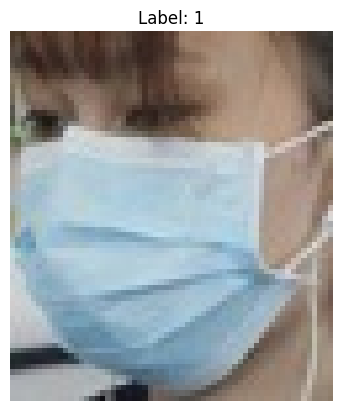

In [ ]:
sample_image = xTest[1]
sample_label = yTest[1]

plt.imshow(sample_image)
plt.title(f"Label: {sample_label}")
plt.axis('off')
plt.show()

# Interest point detection and feature descriptor extraction using SIFT

Some parts of this code are adapted from Lab 6 [1]

In [ ]:
sift = cv2.SIFT_create()

def getFeatureDescriptors(images, labels):         # returns a list of which contains the sift feature descriptors
  descriptorsList = []                             # for each image
  labelsList = []

  for i in range(len(images)):
    # Identify keypoints and extract descriptors with SIFT
    img = img_as_ubyte(color.rgb2gray(images[i]))
    kp, des = sift.detectAndCompute(img, None)

    # Append list of descriptors and label to respective lists
    if des is not None:
        descriptorsList.append(des)
        labelsList.append(labels[i])

  return descriptorsList, labelsList

descriptorsList, yTrainLabels = getFeatureDescriptors(xTrain, yTrain)
descriptorsTrainArray = np.vstack(descriptorsList)

# Model 1 (SIFT - SVM): Hyperparameter fine-tuning (SIFT - SVM)

Setting up hyperparameter space

In [ ]:
kValues = [10, 15, 30, 45, 60, 100, 150]
svmCValues = [0.1, 0.5, 1, 5, 10]
svmGammaValues = ['scale', 'auto', 0.001, 0.01, 0.1]

Grid Search

In [ ]:
resultsFolder = os.path.join(GOOGLE_DRIVE_PATH, 'Code', 'Results', 'siftSVM')

if not os.path.exists(resultsFolder):                 # this code evaluates the performance of each set of hyperparameters for K means
    os.makedirs(resultsFolder)                        # and SVM in the grid search. The results are stored and the best set of
                                                      # hyperparameters according to the average validation accuracy is selected
combinedResults = []

bestSiftSVMAccuracy = 0
bestSifSVMParams = None
bestSiftSVMClassifier = None
bestKmeansSVM = None
scoring = ['neg_log_loss', 'accuracy', 'recall', 'precision', 'f1', 'roc_auc']

for k in kValues:
    print(f"Training KMeans with k = {k}")

    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=randomState).fit(descriptorsTrainArray)

    # Convert descriptors into histograms of codewords for each image. Adapted from Lab 6 [1]
    histogramList = []
    for des in descriptorsList:
        hist = np.zeros(k)
        idx = kmeans.predict(des)  # tells us which codeword (index) each descriptor in the image belongs to in a list
        for j in idx:              # creates normalised histogram of codewords for each image
            hist[j] = hist[j] + (1 / len(des))
        histogramList.append(hist)

    histogramArrayTrain = np.vstack(histogramList)

    svmModel = svm.SVC(probability=True, random_state=randomState)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=randomState)

    paramGrid = [
      {'kernel': ['linear'], 'C': svmCValues},
      {'kernel': ['rbf'], 'C': svmCValues, 'gamma': svmGammaValues}
    ]

    gridSearch = GridSearchCV(
        svmModel,
        paramGrid,
        cv=cv,
        scoring=scoring,
        refit='accuracy',
        n_jobs=-1,
        verbose=3
    )

    gridSearch.fit(histogramArrayTrain, yTrainLabels)

    resultsDF = pd.DataFrame(gridSearch.cv_results_)
    resultsDF['k'] = k
    combinedResults.append(resultsDF)

    resultsFile = os.path.join(resultsFolder, f"svmResultsK{k}.csv")
    resultsDF.to_csv(resultsFile, index=False)
    print(f"Results for k={k} saved to {resultsFile}")

    if gridSearch.best_score_ > bestSiftSVMAccuracy:
        bestSiftSVMAccuracy = gridSearch.best_score_
        bestSiftSVMParams = {'k': k}
        bestSiftSVMParams.update(gridSearch.best_params_)
        bestKmeansSVM = kmeans
        bestSiftSVMClassifier = gridSearch.best_estimator_    # saves the best SIFT-SVM model


allResultsDF = pd.concat(combinedResults, ignore_index=True)
combinedResultsFile = os.path.join(resultsFolder, "All_SIFT_SVM_Results.csv")
allResultsDF.to_csv(combinedResultsFile, index=False)
print(f"Best Parameters: {bestSiftSVMParams}")
print(f"Best Validation Accuracy: {bestSiftSVMAccuracy*100}")

Training KMeans with k = 10
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Results for k=10 saved to /content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Code/Results/siftSVM/svmResultsK10.csv
Training KMeans with k = 15
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Results for k=15 saved to /content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Code/Results/siftSVM/svmResultsK15.csv
Training KMeans with k = 30
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Results for k=30 saved to /content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Code/Results/siftSVM/svmResultsK30.csv
Training KMeans with k = 45
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Results for k=45 saved to /content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Code/Results/siftSVM/svmResultsK45.csv
Training KMeans with k = 60
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Results for k=60 saved to /content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Code/Results/siftSVM/svmResultsK60.csv
Training KMeans with k = 100
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Results for k=100 saved to /content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Code/Results/siftSVM/svmResultsK100.csv
Training KMeans with k = 150
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Results for k=150 saved to /content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Code/Results/siftSVM/svmResultsK150.csv
Best Parameters: {'k': 100, 'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
Best Validation Accuracy: 83.31929824561402


Saving best SIFT-SVM Classifier

In [ ]:
kMeansPath = os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'siftSVM', 'bestKmeansSVM.joblib')
dump(bestKmeansSVM, kMeansPath)

modelPath = os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'siftSVM', 'bestSiftSVMClassifier.joblib')
dump(bestSiftSVMClassifier, modelPath)

['/content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Models/siftSVM/bestSiftSVMClassifier.joblib']

# Evaluating best model on test set (SIFT - SVM)

Loading best SIFT-SVM Classifier

In [ ]:
kMeansPath = os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'siftSVM', 'bestKmeansSVM.joblib')
bestKmeansSVM = load(kMeansPath)

modelPath = os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'siftSVM', 'bestSiftSVMClassifier.joblib')
bestSiftSVMClassifier = load(modelPath)

Creating normalised histogram of codewords for testing set. Some parts of this code are adapted from Lab 6 [1]

In [ ]:
histogramTestList = []                              # this code creates the normalised histogram of codewords using
                                                    # best performing K means for the test set
for i in range(len(xTest)):
    img = img_as_ubyte(color.rgb2gray(xTest[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(bestSiftSVMParams['k']) #100
        idx = bestKmeansSVM.predict(des)
        for j in idx:
            hist[j] = hist[j] + (1 / len(des))
        # hist = scale.transform(hist.reshape(1, -1))
        histogramTestList.append(hist)
    else:
        histogramTestList.append(None)

# Remove potential cases of images with no descriptors
idxNotEmpty = [i for i, x in enumerate(histogramTestList) if x is not None]
histogramTestList = [histogramTestList[i] for i in idxNotEmpty]
yTestUpdated = [yTest[i] for i in idxNotEmpty]
xTestUpdated = [xTest[i] for i in idxNotEmpty]
histogramTestArray = np.vstack(histogramTestList)

In [ ]:
yPred = bestSiftSVMClassifier.predict(histogramTestArray).tolist()   # gets the predictions for the test set using best SIFT-SVM

Qualitative Evaluation

Some parts of this code are adapted from Lab 6 [1]

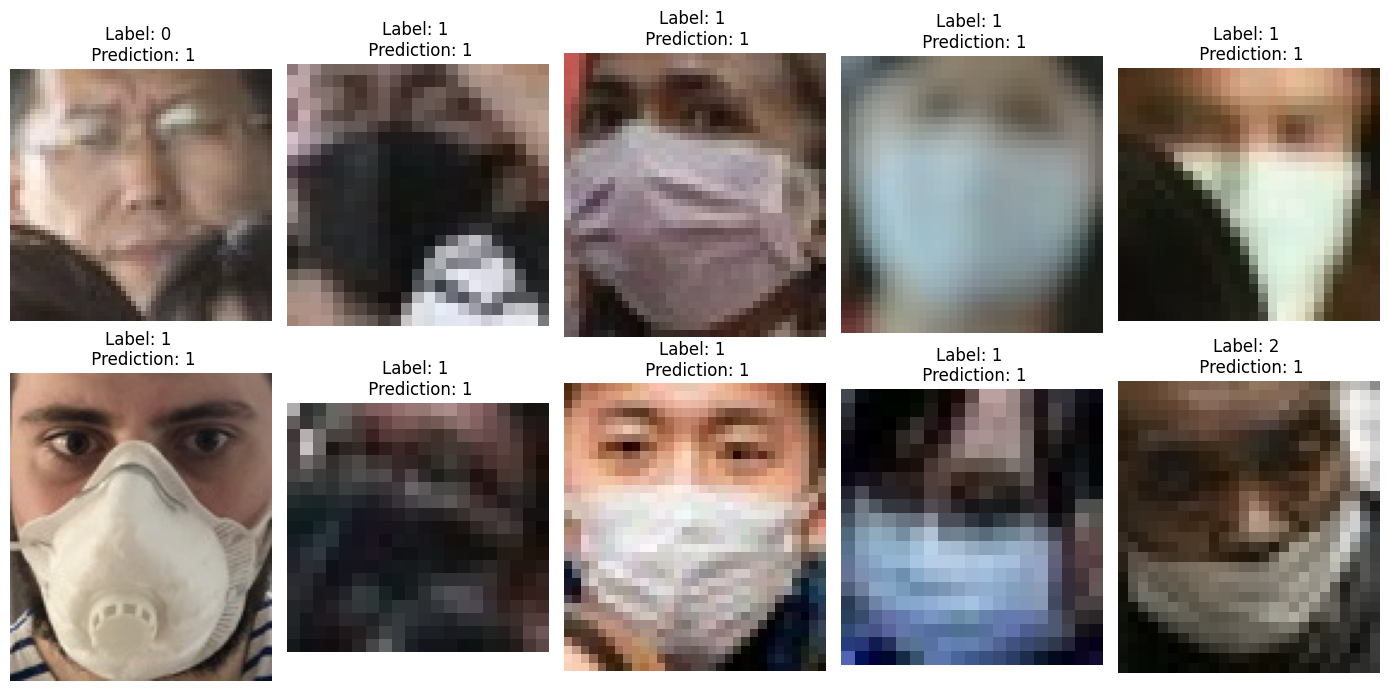

In [ ]:
import random

randomIndices = random.sample(range(len(xTestUpdated)), 10)
fig, axes = plt.subplots(2, 5, figsize=(14, 7))
ax = axes.ravel()

for i, idx in enumerate(randomIndices):
    ax[i].imshow(xTestUpdated[idx])
    ax[i].set_title(f'Label: {yTestUpdated[idx]} \n Prediction: {yPred[idx]}')
    ax[i].set_axis_off()

fig.tight_layout()
plt.show()

Quantitative Evaluation

Some parts of this code are adapted from Lab 6 [1]

In [ ]:
print(f"""Classification report for classifier {bestSiftSVMClassifier}:
      {classification_report(yTestUpdated, yPred, zero_division=0)}\n""")

accuracy = accuracy_score(yTestUpdated, yPred)
precision, recall, f1, _ = precision_recall_fscore_support(yTestUpdated, yPred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy * 100:.1f}%")
print(f"Precision: {precision * 100:.1f}%")
print(f"Recall: {recall * 100:.1f}%")
print(f"F1 Score: {f1 * 100:.1f}%")

Classification report for classifier SVC(C=5, probability=True, random_state=42):
                    precision    recall  f1-score   support

           0       0.45      0.30      0.36        50
           1       0.88      0.96      0.92       384
           2       0.00      0.00      0.00        19

    accuracy                           0.85       453
   macro avg       0.44      0.42      0.43       453
weighted avg       0.79      0.85      0.82       453


Accuracy: 84.5%
Precision: 79.3%
Recall: 84.5%
F1 Score: 81.6%


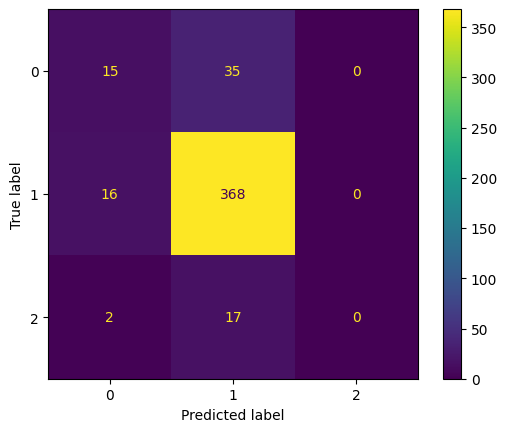

In [ ]:
classLabels = ['0', '1', '2']
cm = confusion_matrix(yTestUpdated, yPred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classLabels)
disp.plot()
plt.show()

# Model 2 (SIFT - MLP): Hyperparameter fine-tuning (SIFT - MLP)

Some parts of this code are adapted from Lab 6 [1]

Setting up hyperparameter space

In [ ]:
kValues = [10, 15, 30, 45, 60, 100, 150]

hidden_layer_sizes = [(10,), (10, 20), (50,), (100,), (100, 50)]
learning_rate_init = [0.001, 0.01, 0.1]

Grid Search

In [ ]:
resultsFolder = os.path.join(GOOGLE_DRIVE_PATH, 'Code', 'Results', 'siftMLP')

if not os.path.exists(resultsFolder):                      # this code evaluates the performance of each set of hyperparameters for K means
    os.makedirs(resultsFolder)                             # and MLP in the grid search. The results are stored. The set of hyperpamraters
                                                           # which give the highest average validation accuracy are selected
combinedResults = []

bestSiftMLPAccuracy = 0
bestSiftMLPParams = None
bestSiftMLPClassifier = None
bestKmeansMLP = None
scoring = ['neg_log_loss', 'accuracy', 'recall', 'precision', 'f1', 'roc_auc']

for k in kValues:
    print(f"Training KMeans with k = {k} ...")

    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=randomState).fit(descriptorsTrainArray)

    # Convert descriptors into histograms of codewords for each image. Adapted from Lab 6 [1]
    histogramList = []
    for des in descriptorsList:
        hist = np.zeros(k)
        idx = kmeans.predict(des)  # tells us which codeword (index) each descriptor in the image belongs to in a list
        for j in idx:              # creates normalised histogram of codewords for each image
            hist[j] = hist[j] + (1 / len(des))
        histogramList.append(hist)

    histogramArrayTrain = np.vstack(histogramList)

    mlpModel = MLPClassifier(max_iter=1000, solver='sgd', activation='relu', random_state=randomState)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=randomState)

    paramGrid = {
      'hidden_layer_sizes': hidden_layer_sizes,
      'learning_rate_init': learning_rate_init
    }

    gridSearch = GridSearchCV(
        mlpModel,
        paramGrid,
        cv=cv,
        scoring=scoring,
        refit='accuracy',
        n_jobs=-1,
        verbose=3
    )

    gridSearch.fit(histogramArrayTrain, yTrainLabels)

    resultsDF = pd.DataFrame(gridSearch.cv_results_)
    resultsDF['k'] = k
    combinedResults.append(resultsDF)

    resultsFile = os.path.join(resultsFolder, f"mlpResultsK{k}.csv")
    resultsDF.to_csv(resultsFile, index=False)
    print(f"Results for k={k} saved to {resultsFile}")

    if gridSearch.best_score_ > bestSiftMLPAccuracy:
        bestSiftMLPAccuracy = gridSearch.best_score_
        bestSiftMLPParams = {'k': k}
        bestSiftMLPParams.update(gridSearch.best_params_)
        bestKmeansMLP = kmeans
        bestSiftMLPClassifier = gridSearch.best_estimator_       # saves the best MLP-SVM model

allResultsDF = pd.concat(combinedResults, ignore_index=True)
combinedResultsFile = os.path.join(resultsFolder, "All_SIFT_MLP_Results.csv")
allResultsDF.to_csv(combinedResultsFile, index=False)
print(f"Best Parameters: {bestSiftMLPParams}")
print(f"Best Validation Accuracy: {bestSiftMLPAccuracy*100}")

Training KMeans with k = 10 ...
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Results for k=10 saved to /content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Code/Results/siftMLP/mlpResultsK10.csv
Training KMeans with k = 15 ...
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Results for k=15 saved to /content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Code/Results/siftMLP/mlpResultsK15.csv
Training KMeans with k = 30 ...
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Results for k=30 saved to /content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Code/Results/siftMLP/mlpResultsK30.csv
Training KMeans with k = 45 ...
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Results for k=45 saved to /content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Code/Results/siftMLP/mlpResultsK45.csv
Training KMeans with k = 60 ...
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Results for k=60 saved to /content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Code/Results/siftMLP/mlpResultsK60.csv
Training KMeans with k = 100 ...
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Results for k=100 saved to /content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Code/Results/siftMLP/mlpResultsK100.csv
Training KMeans with k = 150 ...
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Results for k=150 saved to /content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Code/Results/siftMLP/mlpResultsK150.csv
Best Parameters: {'k': 60, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01}
Best Validation Accuracy: 82.77148567621586


Saving best SIFT-MLP classifier

In [ ]:
kMeansPath = os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'siftMLP', 'bestKmeansMLP.joblib')
dump(bestKmeansMLP, kMeansPath)

modelPath = os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'siftMLP', 'bestSiftMLPClassifier.joblib')
dump(bestSiftMLPClassifier, modelPath)

['/content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Models/siftMLP/bestSiftMLPClassifier.joblib']

# Evaluating best model on test set (SIFT-MLP)

Loading best SIFT-MLP classifier

In [ ]:
kMeansPath = os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'siftMLP', 'bestKmeansMLP.joblib')
bestKmeansMLP = load(kMeansPath)

modelPath = os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'siftMLP', 'bestSiftMLPClassifier.joblib')
bestSiftMLPClassifier = load(modelPath)

Creating normalised histogram of codewords for testing set. Some parts of this code are adapted from Lab 6 [1]

In [ ]:
histogramTestList = []

for i in range(len(xTest)):
    img = img_as_ubyte(color.rgb2gray(xTest[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(bestSiftMLPParams['k']) #60
        idx = bestKmeansMLP.predict(des)
        for j in idx:
            hist[j] = hist[j] + (1 / len(des))
        # hist = scale.transform(hist.reshape(1, -1))
        histogramTestList.append(hist)
    else:
        histogramTestList.append(None)

# Remove potential cases of images with no descriptors
idxNotEmpty = [i for i, x in enumerate(histogramTestList) if x is not None]
histogramTestList = [histogramTestList[i] for i in idxNotEmpty]
yTestUpdated = [yTest[i] for i in idxNotEmpty]
xTestUpdated = [xTest[i] for i in idxNotEmpty]
histogramTestArray = np.vstack(histogramTestList)

In [ ]:
yPred = bestSiftMLPClassifier.predict(histogramTestArray).tolist()    # gets the predictions for the test set using best SIFT-MLP

Qualitative Evaluation

Some parts of this code are adapted from Lab 6 [1]

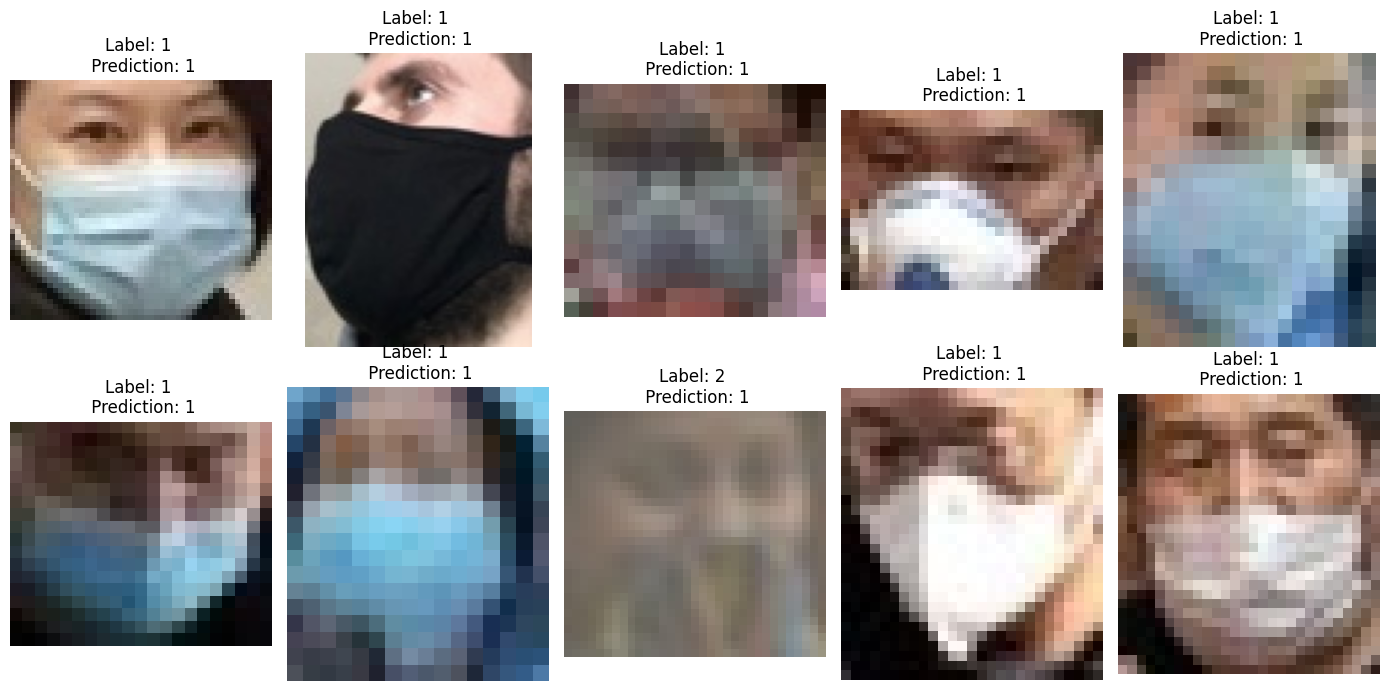

In [ ]:
import random

randomIndices = random.sample(range(len(xTestUpdated)), 10)
fig, axes = plt.subplots(2, 5, figsize=(14, 7))
ax = axes.ravel()

for i, idx in enumerate(randomIndices):
    ax[i].imshow(xTestUpdated[idx])
    ax[i].set_title(f'Label: {yTestUpdated[idx]} \n Prediction: {yPred[idx]}')
    ax[i].set_axis_off()

fig.tight_layout()
plt.show()

Quantitative Evaluation

Some parts of this code are adapted from Lab 6 [1]

In [ ]:
print(f"""Classification report for classifier {bestSiftMLPClassifier}:
      {classification_report(yTestUpdated, yPred, zero_division=0)}\n""")

accuracy = accuracy_score(yTestUpdated, yPred)
precision, recall, f1, _ = precision_recall_fscore_support(yTestUpdated, yPred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy * 100:.1f}%")
print(f"Precision: {precision * 100:.1f}%")
print(f"Recall: {recall * 100:.1f}%")
print(f"F1 Score: {f1 * 100:.1f}%")

Classification report for classifier MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=1000,
              random_state=42, solver='sgd'):
                    precision    recall  f1-score   support

           0       0.49      0.36      0.41        50
           1       0.88      0.96      0.92       384
           2       0.00      0.00      0.00        19

    accuracy                           0.85       453
   macro avg       0.46      0.44      0.44       453
weighted avg       0.80      0.85      0.82       453


Accuracy: 85.0%
Precision: 80.2%
Recall: 85.0%
F1 Score: 82.3%


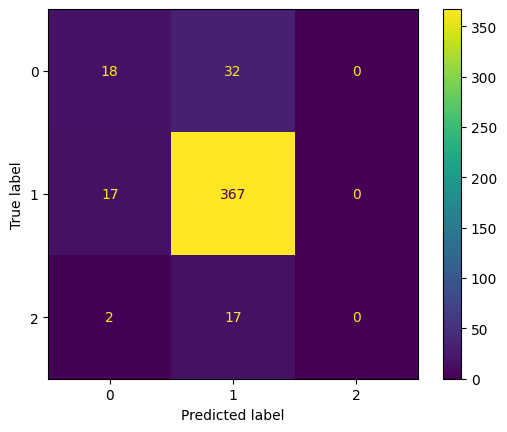

In [ ]:
classLabels = ['0', '1', '2']
cm = confusion_matrix(yTestUpdated, yPred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classLabels)
disp.plot()
plt.show()

# Resizing images for HOG

In [ ]:
xTrainResized = []

for img in xTrain:
  resized = resize(img, (64, 64), anti_aliasing=True)
  xTrainResized.append(resized)

print(len(xTrain))
print(len(xTrainResized))

2394
2394


# Model 3 (HOG - SVM): Hyperparameter fine-tuning (HOG - SVM)

Setting up hyperparameter space

In [ ]:
hogParams = {
    'orientations': [8, 9, 10],
    'pixels_per_cell': [(8, 8), (16, 16)],
    'cells_per_block': [(1, 1), (2,2)]
}

svmCValues = [0.1, 0.5, 1, 5, 10]
svmGammaValues = ['scale', 'auto', 0.001, 0.01, 0.1]

Some parts of this code are adapted from Lab 5 [2]

In [ ]:
resultsFolder = os.path.join(GOOGLE_DRIVE_PATH, 'Code', 'Results', 'hogSVM')

if not os.path.exists(resultsFolder):                   # this code evaluates the performance of each set of hyperparameters for HOG
    os.makedirs(resultsFolder)                          # and SVM in the grid search. The results are stored and the set of
                                                        # hyperparamters which give the highest average validation accuracy are selected
combinedResults = []

bestHogSVMAccuracy = 0
bestHogSVMParams = None
bestHogSVMClassifier = None
scoring = ['neg_log_loss', 'accuracy', 'recall', 'precision', 'f1', 'roc_auc']

for orient in hogParams['orientations']:
    for pix_cell in hogParams['pixels_per_cell']:
        for block_cell in hogParams['cells_per_block']:

            xTrainHog = []
            for img in xTrainResized:
                hogFeature = hog(              # creates the HOG feature for each image. Adapted from Lab 5 [2]
                    img,
                    orientations=orient,
                    pixels_per_cell=pix_cell,
                    cells_per_block=block_cell,
                    visualize=False,
                    channel_axis=2
                )
                xTrainHog.append(hogFeature)

            xTrainHog = np.array(xTrainHog)
            svmModel = svm.SVC(probability=True, random_state=randomState)
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=randomState)

            paramGrid = [
              {'kernel': ['linear'], 'C': svmCValues},
              {'kernel': ['rbf'], 'C': svmCValues, 'gamma': svmGammaValues}
            ]

            gridSearch = GridSearchCV(
                svmModel,
                paramGrid,
                cv=cv,
                scoring=scoring,
                refit='accuracy',
                n_jobs=-1,
                verbose=3
            )

            gridSearch.fit(xTrainHog, yTrain)

            resultsDF = pd.DataFrame(gridSearch.cv_results_)
            resultsDF['orientations'] = orient
            resultsDF['pixels_per_cell'] = str(pix_cell)
            resultsDF['cells_per_block'] = str(block_cell)
            combinedResults.append(resultsDF)

            resultsFile = os.path.join(
                resultsFolder,
                f"hogSVM_orient{orient}_pix{pix_cell[0]}x{pix_cell[1]}_block{block_cell[0]}x{block_cell[1]}.csv"
            )
            resultsDF.to_csv(resultsFile, index=False)
            print(f"Saved results to {resultsFile}")

            if gridSearch.best_score_ > bestHogSVMAccuracy:
                bestHogSVMAccuracy = gridSearch.best_score_
                bestHogSVMParams = {
                    'orientations': orient,
                    'pixels_per_cell': pix_cell,
                    'cells_per_block': block_cell
                }
                bestHogSVMParams.update(gridSearch.best_params_)
                bestHogSVMClassifier = gridSearch.best_estimator_     # saves the best HOG-SVM model

allResultsDF = pd.concat(combinedResults, ignore_index=True)
combinedResultsFile = os.path.join(resultsFolder, "All_HOG_SVM_Results.csv")
allResultsDF.to_csv(combinedResultsFile, index=False)

print(f"\nBest Parameters: {bestHogSVMParams}")
print(f"Best Validation Accuracy: {bestHogSVMAccuracy * 100:.2f}%")

Saving best HOG-SVM Classifier

In [ ]:
modelPath = os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'bestHogSVMClassifier.joblib')
dump(bestHogSVMClassifier, modelPath)

['/content/drive/My Drive/Colab Notebooks/ComputerVision/Coursework/CW_Folder_PG/Models/bestHogSVMClassifier.joblib']

# Evaluating best model on test set (HOG-SVM)

Loading best HOG-SVM model

In [ ]:
modelPath = os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'bestHogSVMClassifier.joblib')
bestHogSVMClassifier = load(modelPath)

Resizing test data

In [ ]:
xTestResized = []

for img in xTest:
  resized = resize(img, (64, 64), anti_aliasing=True)
  xTestResized.append(resized)

Getting HOG features for test set

Some parts of this code are adapted from Lab 5 [2]

In [ ]:
bestHogSVMParams = {'orientations': 10, 'pixels_per_cell': (16, 16), 'cells_per_block': (2, 2), 'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}

xTestHog = []
for img in xTestResized:
    hogFeature = hog(
        img,
        orientations=bestHogSVMParams['orientations'],
        pixels_per_cell=bestHogSVMParams['pixels_per_cell'],
        cells_per_block=bestHogSVMParams['cells_per_block'],
        visualize=False,
        channel_axis=2
    )
    xTestHog.append(hogFeature)

xTestHog = np.array(xTestHog)

In [ ]:
yPred = bestHogSVMClassifier.predict(xTestHog).tolist()    # gets the predictions for the test set using best HOG-SVM

Qualitative Evaluation

Some parts of this code are adapted from Lab 6 [1]

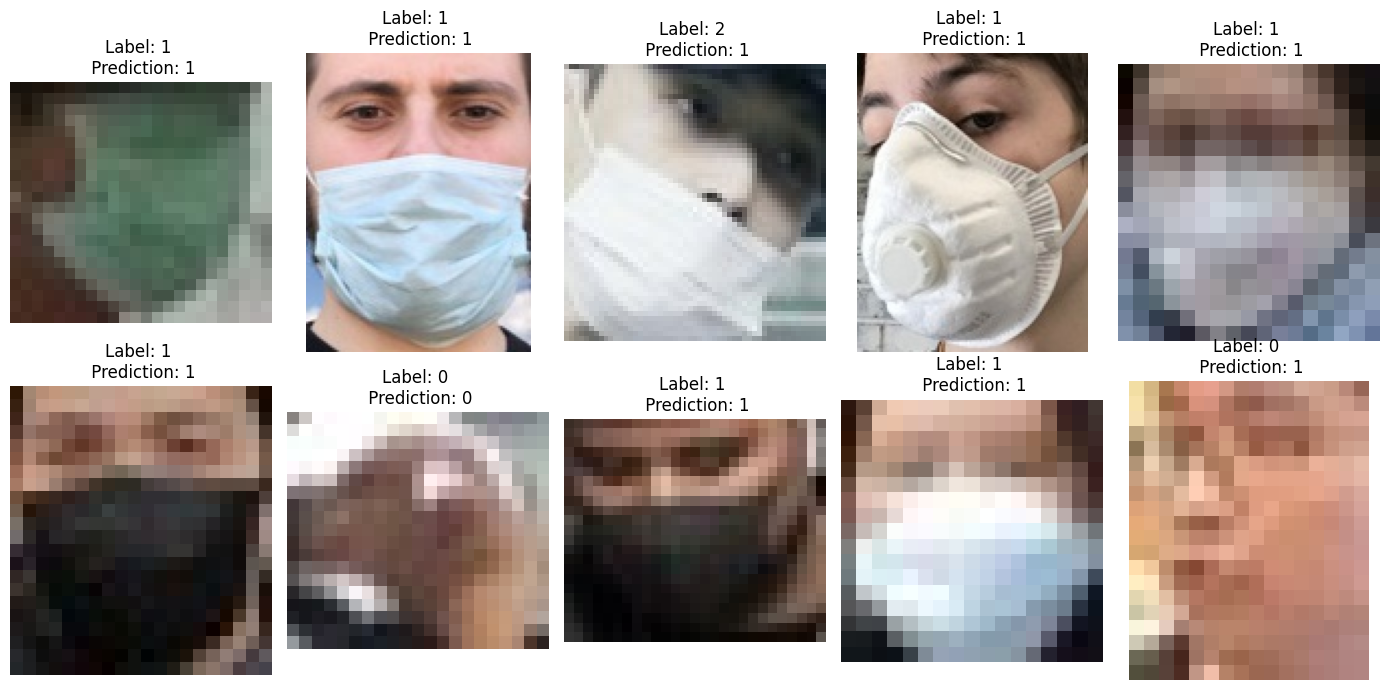

In [ ]:
import random

randomIndices = random.sample(range(len(xTest)), 10)
fig, axes = plt.subplots(2, 5, figsize=(14, 7))
ax = axes.ravel()

for i, idx in enumerate(randomIndices):
    ax[i].imshow(xTest[idx])
    ax[i].set_title(f'Label: {yTest[idx]} \n Prediction: {yPred[idx]}')
    ax[i].set_axis_off()

fig.tight_layout()
plt.show()

Quantitative Evaluation

Some parts of this code are adapted from Lab 6 [1]

In [ ]:
print(f"""Classification report for classifier {bestHogSVMClassifier}:
      {classification_report(yTest, yPred, zero_division=0)}\n""")

accuracy = accuracy_score(yTest, yPred)
precision, recall, f1, _ = precision_recall_fscore_support(yTest, yPred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy * 100:.1f}%")
print(f"Precision: {precision * 100:.1f}%")
print(f"Recall: {recall * 100:.1f}%")
print(f"F1 Score: {f1 * 100:.1f}%")

Classification report for classifier SVC(C=5, probability=True, random_state=42):
                    precision    recall  f1-score   support

           0       0.78      0.63      0.70        51
           1       0.92      0.98      0.95       388
           2       0.83      0.26      0.40        19

    accuracy                           0.91       458
   macro avg       0.85      0.62      0.68       458
weighted avg       0.90      0.91      0.90       458


Accuracy: 90.8%
Precision: 90.3%
Recall: 90.8%
F1 Score: 89.8%


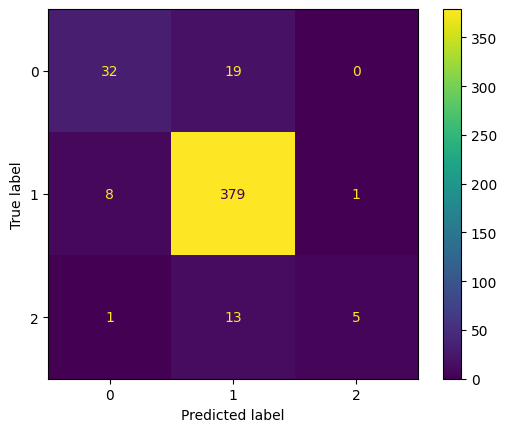

In [ ]:
classLabels = ['0', '1', '2']
cm = confusion_matrix(yTest, yPred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classLabels)
disp.plot()
plt.show()

# Model 4 (CNN): Implementing CNN

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


Preparing data

This code is adapted from Lab 9 [3]

In [ ]:
data_dir = 'CV2024_CW_Dataset'
data_means = [0.485, 0.456, 0.406]
data_stds = [0.229, 0.224, 0.225]

In [ ]:
class MaskDataset(Dataset):
    def __init__(self, root_path, test=False):         # this code creates a custom dataset class which has the instructions on
        self.root_path = root_path                     # how to load the images and labels
        data_transforms = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(data_means, data_stds)
            ]),
            'test': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(data_means, data_stds)
            ]),
        }

        if test:
            self.images = sorted([root_path+"/test/images/"+i for i in os.listdir(root_path+"/test/images/") if not i.startswith('.')])
            self.labels = sorted([root_path+"/test/labels/"+i for i in os.listdir(root_path+"/test/labels") if not i.startswith('.')])
            self.transform = data_transforms['test']
        else:
            self.images = sorted([root_path+"/train/images/"+i for i in os.listdir(root_path+"/train/images/") if not i.startswith('.')])
            self.labels = sorted([root_path+"/train/labels/"+i for i in os.listdir(root_path+"/train/labels/") if not i.startswith('.')])
            self.transform = data_transforms['train']

    def __getitem__(self, index):
      img = Image.open(self.images[index]).convert("RGB")
      labelPath = self.labels[index]
      with open(labelPath, 'r') as file:
          label = file.read().strip()
      label = int(label)
      img = self.transform(img)
      return img, label

    def __len__(self):
        return len(self.images)

# Implementing Hyperparameter fine-tuning (CNN)

Getting train and test dataloaders

This code is adapted from Lab 9 [3]

In [ ]:
BATCH_SIZE = 8
DATA_PATH = "CV2024_CW_Dataset"

trainDataset = MaskDataset(DATA_PATH)                 # the datasets are used to make dataloaders for test and train
trainDataloader = DataLoader(dataset=trainDataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

testDataset = MaskDataset(DATA_PATH, test=True)
testDataloader = DataLoader(dataset=testDataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

Defining training function. This code is adapted from Lab 8 [4]

In [ ]:
def trainModelHyperparam(model, criterion, optimizer, scheduler, dataloader_train, dataset_size, num_epochs):
    since = time.time()
    model.train()
                                                             # this function trains the CNN using the provided hyperparameters
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('----------------')

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader_train:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.double() / dataset_size

        print(f"Train loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}")
        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    return model

Defining hyperparamter gridspace

In [ ]:
learningRates = [0.001, 0.005, 0.01]
momentums = [0.8, 0.9]

In [ ]:
resultsFolder = os.path.join(GOOGLE_DRIVE_PATH, 'Code', 'Results', 'CNN')

if not os.path.exists(resultsFolder):                       # this code evalautes the performance of hyperparameters for CNN's optimiser
    os.makedirs(resultsFolder)                              # in the grid search. The results are stored and the hyperparameters which
                                                            # give the highest average validation accuracy as selected
results = []
kFolds = 5
folds = KFold(n_splits=kFolds, shuffle=True, random_state=randomState)

bestParams = None
highestValAccuracy = 0

for lr in learningRates:
  for momentum in momentums:
    print(f"Trying LR={lr}, Momentum={momentum}")
    foldAccuracies = []

    for fold, (train_idx, val_idx) in enumerate(folds.split(trainDataset)):
       print(f"Fold {fold + 1}/{kFolds}")

       trainFolds = Subset(trainDataset, train_idx)      # divides the training data into training and validation folds
       valFold = Subset(trainDataset, val_idx)

       dataloadersFold = {
            'train': DataLoader(trainFolds, batch_size=4, shuffle=True, num_workers=2),
            'val': DataLoader(valFold, batch_size=4, shuffle=True, num_workers=2)
       }

       datasetSizesFold = {
            'train': len(trainFolds),
            'val': len(valFold)
       }

       modelFold = models.resnet18(weights='IMAGENET1K_V1')     # loads a pretrained ResNet model which is then fine-tuned
       num_ftrs = modelFold.fc.in_features
       modelFold.fc = nn.Linear(num_ftrs, 3)
       modelFold = modelFold.to(device)

       criterion = nn.CrossEntropyLoss()
       optimizer = optim.SGD(modelFold.parameters(), lr=lr, momentum=momentum)
       scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

       trainedModel = trainModelHyperparam(modelFold, criterion, optimizer, scheduler,
                                  dataloadersFold['train'], datasetSizesFold['train'], num_epochs=5)

       modelFold.eval()
       correct = 0
       total = 0
       with torch.no_grad():
          for inputs, labels in dataloadersFold['val']:    # evaluates the trained model on the validation set
              inputs = inputs.to(device)
              labels = labels.to(device)
              outputs = trainedModel(inputs)
              _, preds = torch.max(outputs, 1)
              correct += (preds == labels).sum().item()
              total += labels.size(0)

       acc = correct / total
       print(f"Fold {fold + 1} Validation Accuracy: {acc:.4f}")
       foldAccuracies.append(acc)

    avgAcc = sum(foldAccuracies) / kFolds
    print(f"Average validation accuracy for LR={lr}, Momentum={momentum}: {avgAcc:.4f}")
    results.append([lr, momentum] + foldAccuracies + [avgAcc])

    if avgAcc > highestValAccuracy:     # selects the hyperparameters with the highest average validation accuracy
        highestValAccuracy = avgAcc
        bestParams = (lr, momentum)

# Saving results
csvFilePath = os.path.join(resultsFolder, "cnnResults.csv")
with open(csvFilePath, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Learning Rate', 'Momentum', 'Fold 1 Accuracy', 'Fold 2 Accuracy', 'Fold 3 Accuracy',
                     'Fold 4 Accuracy', 'Fold 5 Accuracy', 'Average Validation Accuracy'])
    for result in results:
        writer.writerow(result)

print(f"\nBest hyperparameters: LR={bestParams[0]}, Momentum={bestParams[1]} with Avg Validation Accuracy: {highestValAccuracy:.4f}")

# Training CNN

Getting train, validation and test dataloaders.

This code is adapted from Lab 9 [3]

In [ ]:
train_dataset, val_dataset = random_split(trainDataset, [0.8, 0.2])

train_dataloader = DataLoader(dataset=train_dataset,        # the train dataset is further split into train and val
                            batch_size=BATCH_SIZE,          # to retrain the CNN using best hyperparameters
                            shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

In [ ]:
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

Defining training function. This code is adapted from Lab 8 [4]

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())             # This function retrains the CNN with the best hyperparameters and
    best_acc = 0.0                                                 # selects the model state which has the epoch with the highest
                                                                   # validation accuracy
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('----------------')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # move data to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # update learning rate with scheduler
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}")

            # deep copy the model with best accuracy on validation set
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val acc: {best_acc:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Importing resnet model and training CNN with best hyperparameters. This code is adapted from Lab 8 [4]

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')     # loads a pretrained ResNet model which is then fine-tuned
                                                        # using the training data
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)
model_ft = model_ft.to(device)

Defining criterion and optimiser (using best hyperparameters) for CNN. This code is adapted from Lab 8 [4]

In [ ]:
criterion = nn.CrossEntropyLoss()

bestParams = (0.001, 0.8)      # defines the optimiser with the best hyperparameters
optimizer_ft = optim.SGD(model_ft.parameters(), lr=bestParams[0], momentum=bestParams[1])

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)   # retrains the CNN using the best hyperparameters

Epoch 0/24
----------------
train loss: 0.3898 acc: 0.8606
val loss: 0.2614 acc: 0.9289

Epoch 1/24
----------------
train loss: 0.2983 acc: 0.9066
val loss: 0.2406 acc: 0.9121

Epoch 2/24
----------------
train loss: 0.2856 acc: 0.9092
val loss: 0.1892 acc: 0.9372

Epoch 3/24
----------------
train loss: 0.2496 acc: 0.9175
val loss: 0.2296 acc: 0.9121

Epoch 4/24
----------------
train loss: 0.2420 acc: 0.9222
val loss: 0.2272 acc: 0.9372

Epoch 5/24
----------------
train loss: 0.2231 acc: 0.9269
val loss: 0.2155 acc: 0.9351

Epoch 6/24
----------------
train loss: 0.2005 acc: 0.9332
val loss: 0.2280 acc: 0.9142

Epoch 7/24
----------------
train loss: 0.1883 acc: 0.9363
val loss: 0.2011 acc: 0.9226

Epoch 8/24
----------------
train loss: 0.1652 acc: 0.9431
val loss: 0.1940 acc: 0.9372

Epoch 9/24
----------------
train loss: 0.1797 acc: 0.9421
val loss: 0.2002 acc: 0.9289

Epoch 10/24
----------------
train loss: 0.1828 acc: 0.9374
val loss: 0.1668 acc: 0.9477

Epoch 11/24
--------

Saving best CNN model

In [ ]:
modelPath = os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'bestCNNClassifier.pth')
torch.save(model_ft.state_dict(), modelPath)

# Evaluating best model on test set (CNN)

In [ ]:
def testModel(model, testLoader, criterion, device):    # this function calculates the accuracy, loss and gets the
    model.eval()                                        # predictions and labels for the best CNN
    corrects = 0
    total = 0
    runningLoss = 0.0
    allPreds = []
    allLabels = []

    with torch.no_grad():
        for inputs, labels in testLoader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            runningLoss += loss.item() * inputs.size(0)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

            allPreds.extend(preds.cpu().numpy())
            allLabels.extend(labels.cpu().numpy())


    accuracy = corrects.double() / total
    avg_loss = runningLoss / total

    return accuracy, avg_loss, allPreds, allLabels

In [ ]:
accuracy, avgLoss, predictions, trueLabels = testModel(model_ft, testDataloader, criterion, device)

Qualitative Evaluation

Some parts of this code are adapted from Lab 9 [3] and Lab 8 [4]

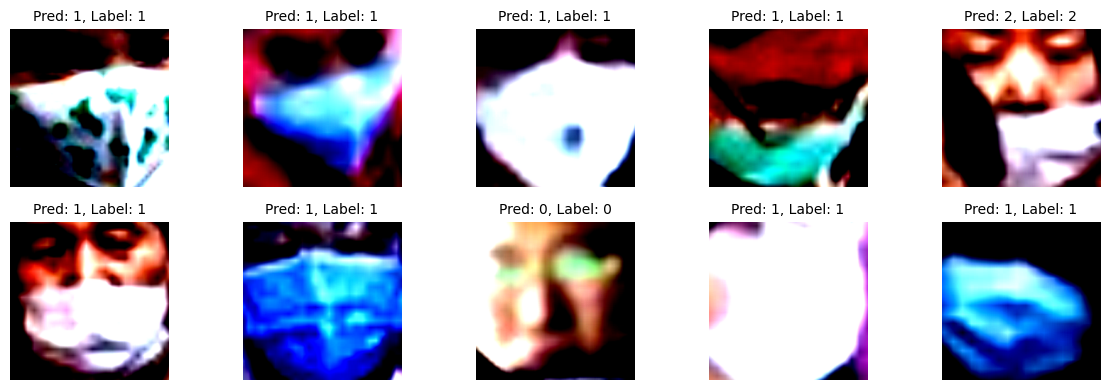

In [ ]:
def imshow(inp, title=None, ax=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title, fontsize=10)
    ax.axis('off')

def visualize_model(model, num_images=10):        # extracts 10 images from the test set and displays them along with their
    was_training = model.training                 # labels and model predictions. Adapted from Lab 8 [4]
    model.eval()
    images_so_far = 0

    fig, axs = plt.subplots(2, num_images//2, figsize=(12, 4))
    axs = axs.flatten()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testDataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return

                ax = axs[images_so_far]
                title = f"Pred: {class_names[preds[j]]}, Label: {class_names[labels[j]]}"
                imshow(inputs.cpu().data[j], title=title, ax=ax)
                images_so_far += 1

    model.train(mode=was_training)


class_names = ['0', '1', '2']
visualize_model(model_ft)

Quantitative Analysis

Some parts of this code are adapted from Lab 6 [1]

In [ ]:
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Loss: {avgLoss:.4f}')

print(f"\nClassification report for CNN:\n{classification_report(trueLabels, predictions, zero_division=0)}")

accuracy = accuracy_score(trueLabels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(trueLabels, predictions, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy * 100:.1f}%")
print(f"Precision: {precision * 100:.1f}%")
print(f"Recall: {recall * 100:.1f}%")
print(f"F1 Score: {f1 * 100:.1f}%")

Test Accuracy: 0.9585
Test Loss: 0.1085

Classification report for CNN:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        51
           1       0.97      0.99      0.98       388
           2       0.82      0.47      0.60        19

    accuracy                           0.96       458
   macro avg       0.90      0.78      0.83       458
weighted avg       0.96      0.96      0.96       458

Accuracy: 95.9%
Precision: 95.6%
Recall: 95.9%
F1 Score: 95.5%


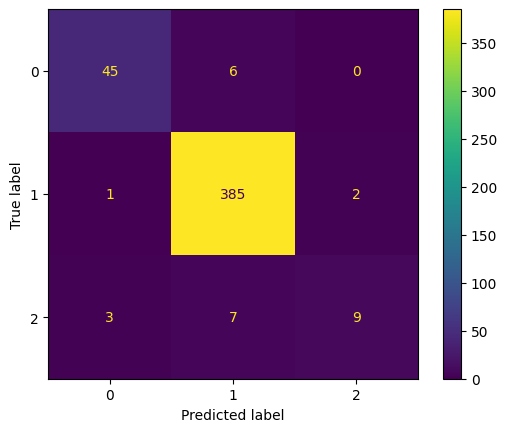

In [ ]:
classLabels = ['0', '1', '2']
cm = confusion_matrix(trueLabels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classLabels)
disp.plot()
plt.show()

# References

[1] G. Tarroni, Lab Tutorial 06, Computer Vision - IN3060/INM460, School of Science & Technology, Department of Computer Science, City, University of London, London, U.K., 2025

[2] G. Tarroni, Lab Tutorial 05, Computer Vision - IN3060/INM460, School of Science & Technology, Department of Computer Science, City, University of London, London, U.K., 2025

[3] G. Tarroni, Lab Tutorial 09, Computer Vision - IN3060/INM460, School of Science & Technology, Department of Computer Science, City, University of London, London, U.K., 2025

[4] G. Tarroni, Lab Tutorial 08, Computer Vision - IN3060/INM460, School of Science & Technology, Department of Computer Science, City, University of London, London, U.K., 2025